안산시 데이터 온도 측정지점을 기준으로 3곳으로 나눌 수 있음.

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

In [2]:
data1 = pd.read_csv('dataset/1.안산시_기상데이터.csv')

# addr column 값 통일
data1['addr'] = data1['addr'].replace('경기도 안산시단원구 고잔동', '경기도 안산시 단원구 고잔동')

# '날짜' 컬럼을 datetime 형식으로 변환 및 정렬
data1['obsrv_ymd'] = pd.to_datetime(data1['obsrv_ymd'], format='%Y%m%d')
data1 = data1.sort_values(by='obsrv_ymd')

# 이상한 row들 제거
data1 = data1[data1['wnd_drctn'] >= 0.0] # 풍향이 0 이하인 row들 제거, 측정오류로 처리
data1 = data1[(data1['wnd_drctn'] != 0.0) & (data1['wnd_spd'] != 0.0)] # 풍향과 풍속 전부 0인 row들 제거, 측정오류로 처리
data1 = data1[data1['temp'] > -50.0] # 온도가 -50도 이하인 row들 제거, 측정오류로 처리
data1 = data1[data1['hmdt'] >= 0.0] # 습도가 0도 미만인 row들 제거, 측정오류로 처리
data1 = data1[(data1['prcp_tm'] >= 0.0) & (data1['prcp_dy'] >= 0.0)] # 시간 및 누적 강우량 전부 0인 row들 제거, 측정오류로 처리
data1

,obsrv_cd,obsrv_nm,addr,obsrv_ymd,obsrv_tm,lon,lat,heigt,wnd_drctn,wnd_spd,temp,hmdt,atm_prs,atm_prs_si,prcp_tm,prcp_dy
17421,545,안산,경기도 안산시 사동,2019-01-01,17,126.8385,37.2810,5.92,302.4,2.6,-1.4,60.2,-997,-997,0.0,0.0
17430,435,고잔,경기도 안산시 단원구 고잔동,2019-01-01,12,126.8212,37.3243,32.00,316.4,2.7,-2.3,57.8,-997,-997,0.0,0.0
17429,435,고잔,경기도 안산시 단원구 고잔동,2019-01-01,13,126.8212,37.3243,32.00,289.1,2.7,-2.4,63.5,-997,-997,0.0,0.0
17426,435,고잔,경기도 안산시 단원구 고잔동,2019-01-01,14,126.8212,37.3243,32.00,301.1,3.1,-2.2,65.6,-997,-997,0.0,0.0
17425,545,안산,경기도 안산시 사동,2019-01-01,15,126.8385,37.2810,5.92,302.4,1.1,-0.9,62.6,-997,-997,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64208,435,고잔,경기도 안산시 단원구 고잔동,2023-01-31,8,126.8340,37.3326,73.00,116.7,3.4,-1.8,68.0,-997,-997,0.0,0.0
67524,435,고잔,경기도 안산시 단원구 고잔동,2023-01-31,23,126.8340,37.3326,73.00,264.1,3.2,5.7,97.0,-997,-997,0.0,0.0
67525,545,안산,경기도 안산시 사동,2023-01-31,23,126.8385,37.2810,5.92,45.6,0.1,2.6,89.6,-997,-997,0.0,0.0
66428,435,고잔,경기도 안산시 단원구 고잔동,2023-01-31,18,126.8340,37.3326,73.00,213.5,3.4,6.3,73.7,-997,-997,0.0,0.0


In [3]:
data1_1 = data1[(data1['lon'] == 126.8385) & (data1['lat'] == 37.2810)]
data1_2 = data1[(data1['lon'] == 126.8212) & (data1['lat'] == 37.3243)]
data1_3 = data1[(data1['lon'] == 126.8340) & (data1['lat'] == 37.3326)]

In [4]:
# 사용자 정의 함수: 문자열 열을 그대로 반환하는 함수
def keep_string(column):
    return column.iloc[0]  # 첫 번째 값을 반환합니다.

In [5]:
def mean_to(column):
    lst_mean = np.mean(column.tolist())
    if len([i for i in column.tolist() if i >= lst_mean]) > len([i for i in column.tolist() if i <= lst_mean]):
        return sum([i for i in column.tolist() if i >= lst_mean])/len([i for i in column.tolist() if i >= lst_mean])
    elif len([i for i in column.tolist() if i >= lst_mean]) < len([i for i in column.tolist() if i <= lst_mean]):
        return sum([i for i in column.tolist() if i <= lst_mean])/len([i for i in column.tolist() if i <= lst_mean])
    else:
        return lst_mean

In [18]:
result1_1 = data1_1.groupby('obsrv_ymd').agg({'temp': 'mean', 'hmdt': 'mean'}).reset_index()
result1_2 = data1_2.groupby('obsrv_ymd').agg({'temp': 'mean', 'hmdt': 'mean'}).reset_index()
result1_3 = data1_3.groupby('obsrv_ymd').agg({'temp': 'mean', 'hmdt': 'mean'}).reset_index()

In [19]:
def mksubplot(dataframe):
    # 서로 다른 서브플롯을 가진 그림 생성
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('온도', '습도'))

    # 온도 그래프 (서브플롯 1)
    fig.add_trace(go.Scatter(x=dataframe['obsrv_ymd'], y=dataframe['temp'], mode='lines', name='온도 (°C)', line=dict(color='blue')), row=1, col=1)
    fig.update_yaxes(title_text='온도 (°C)', showline=True, linewidth=1, linecolor='red', row=1, col=1, tickvals=list(range(-20, 41, 10)))
    fig.update_xaxes(title_text='날짜', row=1, col=1, showticklabels=True)

    # 습도 그래프 (서브플롯 2)
    fig.add_trace(go.Scatter(x=dataframe['obsrv_ymd'], y=dataframe['hmdt'], mode='lines', name='습도 (%)', line=dict(color='red')), row=2, col=1)
    fig.update_yaxes(title_text='습도 (%)', showline=True, linewidth=1, linecolor='blue', row=1, col=2, tickvals=list(range(0, 101, 10)))
    fig.update_xaxes(title_text='날짜', row=2, col=1, showticklabels=True)

    # 그림 레이아웃 설정
    fig.update_layout(title='온도와 습도 시계열 데이터', showlegend=True, height=500, width=800)

    # Plotly 그래프를 이미지로 저장
    img_bytes = fig.to_image(format="png")

    # 이미지를 base64로 인코딩
    img_base64 = b64encode(img_bytes).decode()

    return img_base64 #base64 형식으로 내보내기

In [20]:
result1_1

,obsrv_ymd,temp,hmdt
0,2019-01-01,-3.600000,64.828571
1,2019-01-02,-4.566667,55.366667
2,2019-01-03,-3.436364,51.718182
3,2019-01-04,-1.133333,65.766667
4,2019-01-05,-4.046667,58.266667
...,...,...,...
1469,2023-01-27,-7.745000,53.405000
1470,2023-01-28,-6.004545,54.231818
1471,2023-01-29,-0.011765,60.111765
1472,2023-01-30,-0.550000,52.300000


In [21]:
result1_2

,obsrv_ymd,temp,hmdt
0,2019-01-01,-4.236364,66.050000
1,2019-01-02,-4.790909,59.895455
2,2019-01-03,-3.683333,52.912500
3,2019-01-04,-2.031579,70.600000
4,2019-01-05,-2.495455,46.731818
...,...,...,...
798,2021-05-09,14.743478,61.578261
799,2021-05-10,11.652174,90.956522
800,2021-05-11,17.570833,56.341667
801,2021-05-12,20.675000,38.137500


### 지점별 온도시계열변화 시각화

In [22]:
# import io
# from PIL import Image
from base64 import b64encode

coordinate_lst = [[37.2810, 126.8385], [37.3243, 126.8212], [37.3326, 126.8340]]
img_base64_lst = [mksubplot(result1_1), mksubplot(result1_2), mksubplot(result1_3)]

# Folium 지도 생성
m = folium.Map(location=[37.287, 126.8385], zoom_start=12)

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# 이미지를 팝업에 추가
for coordinate,base64 in zip(coordinate_lst, img_base64_lst):
    popup = folium.Popup(folium.Html(f'<img src="data:image/png;base64,{base64}">', script=True), max_width=800)
    marker = folium.Marker(location=coordinate, popup=popup)
    marker.add_to(m)

# 지도를 화면에 표시
m.save('weather_map.html')  # HTML 파일로 저장

## 3.안산시_가로수 현황 시각화

In [15]:
# GeoJSON 파일 불러오기
with open('dataset/3.안산시_가로수현황.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
street_trees_df = pd.json_normalize(geojson_data['features'])
street_trees_df['geometry.coordinates'] = street_trees_df['geometry.coordinates'].apply(lambda x : x[0])
street_trees_df['lon'] = street_trees_df['geometry.coordinates'].apply(lambda x : x[0])
street_trees_df['lat'] = street_trees_df['geometry.coordinates'].apply(lambda x : x[1])
street_trees_df

,type,properties.HJD_CDE,properties.BJD_CDE,geometry.type,geometry.coordinates,lon,lat
0,Feature,4127357000,4127310400,MultiPoint,"[126.77130981479182, 37.29558311978244]",126.771310,37.295583
1,Feature,4127357000,4127310400,MultiPoint,"[126.77122642985587, 37.29560702529468]",126.771226,37.295607
2,Feature,4127357000,4127310400,MultiPoint,"[126.77114090430125, 37.29563016973914]",126.771141,37.295630
3,Feature,4127357000,4127310400,MultiPoint,"[126.77105525924954, 37.2956555124169]",126.771055,37.295656
4,Feature,4127357000,4127310400,MultiPoint,"[126.77096827268889, 37.2956806361881]",126.770968,37.295681
...,...,...,...,...,...,...,...
68838,Feature,4127357000,4127310400,MultiPoint,"[126.73935732916034, 37.30140089565829]",126.739357,37.301401
68839,Feature,4127357000,4127310400,MultiPoint,"[126.73939465578442, 37.301468384206125]",126.739395,37.301468
68840,Feature,4127357000,4127310400,MultiPoint,"[126.73946116266923, 37.30160096460182]",126.739461,37.301601
68841,Feature,4127357000,4127310400,MultiPoint,"[126.73943989009794, 37.30203909055725]",126.739440,37.302039


### folium.LayerControl() 기억해두기

In [16]:
from folium.plugins import MarkerCluster
# Folium 지도 생성
center_lat = np.mean(street_trees_df['lat'])
center_lon = np.mean(street_trees_df['lon'])
m = folium.Map(location=[center_lat, center_lon], zoom_start=13, width='100%', height='100%')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# 마커 클러스터 생성
marker_cluster = MarkerCluster().add_to(m)

# GeoJSON 데이터를 지도에 추가
for index, row in street_trees_df.iterrows():
    marker = folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3,
        fill=True,
    )
    marker.add_to(marker_cluster)

# 지도 저장
m.save('street_trees_clustering.html')

### 도시공원 현황

In [12]:
park_df = pd.read_csv('dataset/4.안산시_도시공원현황.csv')
park_df

,park_nm,park_gbn,address,area,lon,lat
0,각골공원,근린공원,경기도 안산시 상록구 본오동 45-6,49303.0,126.874151,37.291292
1,반월공원,근린공원,경기도 안산시 상록구 본오동 723,44732.4,126.869552,37.289870
2,상록수공원,문화공원,경기도 안산시 상록구 본오동 879-4,12325.8,126.862742,37.299643
3,본오공원,근린공원,경기도 안산시 상록구 본오동 산39,123747.0,126.868576,37.300955
4,오목골공원,근린공원,경기도 안산시 상록구 본오동 산80-1,47210.0,126.860578,37.288462
...,...,...,...,...,...,...
190,도토리공원,소공원,경기도 안산시 단원구 고잔동 782-5,4731.0,126.832012,37.307241
191,원곡3문화공원,문화공원,경기도 안산시 단원구 원곡동 852,3645.0,126.803681,37.324755
192,원곡3소공원,소공원,경기도 안산시 단원구 원곡동 854,5507.0,126.804429,37.323728
193,초지1소공원,소공원,경기도 안산시 단원구 초지동 595-3,4864.0,126.806747,37.322585


In [13]:
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'}
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
    return DataFrame

In [18]:
park_df = geo_transform(park_df)
park_df

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,park_nm,park_gbn,address,area,lon,lat,geometry
0,각골공원,근린공원,경기도 안산시 상록구 본오동 45-6,49303.0,126.874151,37.291292,POINT (126.87415 37.29129)
1,반월공원,근린공원,경기도 안산시 상록구 본오동 723,44732.4,126.869552,37.289870,POINT (126.86955 37.28987)
2,상록수공원,문화공원,경기도 안산시 상록구 본오동 879-4,12325.8,126.862742,37.299643,POINT (126.86274 37.29964)
3,본오공원,근린공원,경기도 안산시 상록구 본오동 산39,123747.0,126.868576,37.300955,POINT (126.86858 37.30096)
4,오목골공원,근린공원,경기도 안산시 상록구 본오동 산80-1,47210.0,126.860578,37.288462,POINT (126.86058 37.28846)
...,...,...,...,...,...,...,...
190,도토리공원,소공원,경기도 안산시 단원구 고잔동 782-5,4731.0,126.832012,37.307241,POINT (126.83201 37.30724)
191,원곡3문화공원,문화공원,경기도 안산시 단원구 원곡동 852,3645.0,126.803681,37.324755,POINT (126.80368 37.32476)
192,원곡3소공원,소공원,경기도 안산시 단원구 원곡동 854,5507.0,126.804429,37.323728,POINT (126.80443 37.32373)
193,초지1소공원,소공원,경기도 안산시 단원구 초지동 595-3,4864.0,126.806747,37.322585,POINT (126.80675 37.32258)


In [24]:
# map 생성
m = folium.Map(location=[37.291292, 126.874151],  zoom_start=11, tiles='CartoDB positron')

# 배경지도 타일 설정하기
layer = "Hybrid"
tileType = "png"
tiles = f"http://api.vworld.kr/req/wmts/1.0.0/{vworld_key}/{layer}/{{z}}/{{y}}/{{x}}.{tileType}"
attr = "Vworld"

folium.TileLayer(
    tiles=tiles,
    attr=attr,
    overlay=True,
    control=True
).add_to(m)

# area를 통해 radius를 계산하는 함수
def calculate_radius_from_area(area):
    radius = math.sqrt(area / math.pi)
    return radius

for _, row in park_df.iterrows() :
    radius = calculate_radius_from_area(row['area'])  # 면적(m^2)을 원으로 가정하여 radius계산
    folium.Circle(location=(row['lat'], row['lon']), radius=radius, color='#FF580B',
            fill='#FF580B').add_to(m)
    
m.save('park_area_radius.html')

### 하천현황

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/5.안산시_하천현황.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
river_df = pd.json_normalize(geojson_data['features'])
river_df

In [ ]:
river_df['geometry'] = river_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
river_df

In [103]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in river_df.iterrows():
    folium.GeoJson(row['geometry'].__geo_interface__).add_to(m)
    
m.save('river_area.html')

### 토지피복현황도

In [ ]:
# GeoJSON 파일 불러오기
with open('dataset/6.안산시_토지피복현황도.geojson', 'r') as geojson_file:
    geojson_data = json.load(geojson_file)
land_cover_df = pd.json_normalize(geojson_data['features'])
land_cover_df['geometry'] = land_cover_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
land_cover_df['properties.피복-대분류'] = land_cover_df['properties.피복-대분류'].apply(lambda x : x.split('. ')[1])
land_cover_df['properties.피복-중분류'] = land_cover_df['properties.피복-중분류'].apply(lambda x : x.split('. ')[1])
land_cover_df['properties.피복-소분류'] = land_cover_df['properties.피복-소분류'].apply(lambda x : x.split('. ')[1])
land_cover_df

In [141]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.피복-대분류']
    if category == '불투수':
        return 'darkred'
    elif category == '투수':
        return 'yellow'
    elif category == '녹지':
        return 'darkgreen'
    else:
        return 'darkblue'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in land_cover_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.피복-소분류']}({row['properties.피복-대분류']} - {row['properties.피복-중분류']})"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('land_cover.html')

### 현존 식생도

In [25]:
# GeoJSON 파일 불러오기
with open('dataset/7.안산시_현존식생도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
vegetation_map_df = pd.json_normalize(geojson_data['features'])
vegetation_map_df['geometry'] = vegetation_map_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
vegetation_map_df['properties.현존식생유형_소분류'] = vegetation_map_df['properties.현존식생유형_소분류'].apply(lambda x : x.split('. ')[1])
vegetation_map_df

,type,properties.현존식생유형_소분류,properties.현존식생유형_세분류,properties.현존식생유형_구분,geometry.type,geometry.coordinates,geometry
0,Feature,이차림,상수리나무-굴참나무군락,산지낙엽활엽수림,MultiPolygon,"[[[[126.84374987651165, 37.36017593517266, 0.0...",POLYGON Z ((126.84374987651165 37.360175935172...
1,Feature,이차림,상수리나무-갈참나무군락,산지낙엽활엽수림,MultiPolygon,"[[[[126.84992693171938, 37.3623689488233, 0.0]...",POLYGON Z ((126.84992693171938 37.362368948823...
2,Feature,이차림,상수리나무-굴참나무군락,산지낙엽활엽수림,MultiPolygon,"[[[[126.85079467412422, 37.35946627673895, 0.0...",POLYGON Z ((126.85079467412422 37.359466276738...
3,Feature,이차림,상수리나무-갈참나무군락,산지낙엽활엽수림,MultiPolygon,"[[[[126.84374987651165, 37.36017593517266, 0.0...",POLYGON Z ((126.84374987651165 37.360175935172...
4,Feature,잔디식재지,D11. 잔디식재지,기타식생,MultiPolygon,"[[[[126.85092416789732, 37.361073411155786, 0....",POLYGON Z ((126.85092416789732 37.361073411155...
...,...,...,...,...,...,...,...
7113,Feature,시가지,A11. 시가지,비식생,MultiPolygon,"[[[[126.80108601043415, 37.342478214261135, 0....",POLYGON Z ((126.80108601043415 37.342478214261...
7114,Feature,가로수가 식재되지 않은 도로,A21. 가로수가 식재되지 않은 도로,비식생,MultiPolygon,"[[[[126.75033331114372, 37.328385629553566, 0....",POLYGON Z ((126.75033331114372 37.328385629553...
7115,Feature,층위조성되지 않은 외래종수목식재지,D31. 층위조성되지 않은 외래종수목식재지,기타식생,MultiPolygon,"[[[[126.91384264493489, 37.29652770258018, 0.0...",POLYGON Z ((126.91384264493489 37.296527702580...
7116,Feature,논,C11. 논,기타식생,MultiPolygon,"[[[[126.9238324319318, 37.28543735467033, 0.0]...",POLYGON Z ((126.9238324319318 37.2854373546703...


In [142]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.현존식생유형_구분']
    if category == '비식생':
        return 'darkred'
    else:
        return 'darkgreen'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in vegetation_map_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.현존식생유형_구분']}(properties.현존식생유형_소분류)"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('vegetation_map.html')

### 연속지적도

In [30]:
def make_geo(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])

In [161]:
# GeoJSON 파일 불러오기
with open('dataset/8.안산시_연속지적도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
registration_map_df = pd.json_normalize(geojson_data['features'])
registration_map_df['geometry'] = registration_map_df['geometry.coordinates'].apply(lambda x : make_geo(x))
registration_map_df

,type,properties.jibun,properties.pnu,geometry.type,geometry.coordinates,geometry
0,Feature,537-6대,4127110100105370006,Polygon,"[[[126.86455223208655, 37.316952069431515], [1...",POLYGON ((126.86455223208655 37.31695206943151...
1,Feature,559-13대,4127110100105590013,Polygon,"[[[126.86179206428146, 37.31692604694183], [12...",POLYGON ((126.86179206428146 37.31692604694183...
2,Feature,541-7대,4127110100105410007,Polygon,"[[[126.86344840613782, 37.3169206925515], [126...","POLYGON ((126.86344840613782 37.3169206925515,..."
3,Feature,559-10대,4127110100105590010,Polygon,"[[[126.8613822727095, 37.316528570263664], [12...",POLYGON ((126.8613822727095 37.316528570263664...
4,Feature,540-4대,4127110100105400004,Polygon,"[[[126.86422893347417, 37.31662768579499], [12...",POLYGON ((126.86422893347417 37.31662768579499...
...,...,...,...,...,...,...
65071,Feature,105-1도,4127110600101050001,Polygon,"[[[126.84645334884664, 37.35043177565401], [12...",POLYGON ((126.84645334884664 37.35043177565401...
65072,Feature,91-2 도,4127110600100910002,Polygon,"[[[126.84695039768427, 37.35290009656722], [12...",POLYGON ((126.84695039768427 37.35290009656722...
65073,Feature,64-10 도,4127110600100640010,Polygon,"[[[126.84644963809912, 37.35397018693188], [12...",POLYGON ((126.84644963809912 37.35397018693188...
65074,Feature,90-3 도,4127110600100900003,Polygon,"[[[126.84706122294956, 37.353902509430256], [1...",POLYGON ((126.84706122294956 37.35390250943025...


In [162]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in vegetation_map_df.iterrows():
    folium.GeoJson(
        row['geometry'].__geo_interface__,
    ).add_to(m)
    
m.save('registration_map.html')

### 토지이용현황도

In [175]:
# GeoJSON 파일 불러오기
with open('dataset/9.안산시_토지이용현황도.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
land_use_df = pd.json_normalize(geojson_data['features'])
land_use_df['geometry'] = land_use_df['geometry.coordinates'].apply(lambda x : Polygon(x[0][0]))
land_use_df['properties.이용현황-대분류'] = land_use_df['properties.이용현황-대분류'].apply(lambda x : x.split('. ')[1])
land_use_df['properties.이용현황-중분류'] = land_use_df['properties.이용현황-중분류'].apply(lambda x : x.split('. ')[1])
land_use_df['properties.이용현황-소분류'] = land_use_df['properties.이용현황-소분류'].apply(lambda x : x.split('. ')[1])
land_use_df

,type,properties.이용현황-대분류,properties.이용현황-중분류,properties.이용현황-소분류,geometry.type,geometry.coordinates,geometry
0,Feature,산림지역,활엽수림,활엽수림,MultiPolygon,"[[[[126.84374987651165, 37.36017593517266, 0.0...",POLYGON Z ((126.84374987651165 37.360175935172...
1,Feature,산림지역,활엽수림,활엽수림,MultiPolygon,"[[[[126.84992693171938, 37.3623689488233, 0.0]...",POLYGON Z ((126.84992693171938 37.362368948823...
2,Feature,산림지역,활엽수림,활엽수림,MultiPolygon,"[[[[126.85079467412422, 37.35946627673895, 0.0...",POLYGON Z ((126.85079467412422 37.359466276738...
3,Feature,산림지역,활엽수림,활엽수림,MultiPolygon,"[[[[126.84374987651165, 37.36017593517266, 0.0...",POLYGON Z ((126.84374987651165 37.360175935172...
4,Feature,초지,인공초지,묘지,MultiPolygon,"[[[[126.85092416789732, 37.361073411155786, 0....",POLYGON Z ((126.85092416789732 37.361073411155...
...,...,...,...,...,...,...,...
7113,Feature,시가화 건조지역,교통지역,기타 교통·통신시설,MultiPolygon,"[[[[126.80108601043415, 37.342478214261135, 0....",POLYGON Z ((126.80108601043415 37.342478214261...
7114,Feature,시가화 건조지역,교통지역,도로,MultiPolygon,"[[[[126.75033331114372, 37.328385629553566, 0....",POLYGON Z ((126.75033331114372 37.328385629553...
7115,Feature,시가화 건조지역,문화체육휴양지역,문화체육휴양시설,MultiPolygon,"[[[[126.91384264493489, 37.29652770258018, 0.0...",POLYGON Z ((126.91384264493489 37.296527702580...
7116,Feature,농업지역,논,경지정리가 안 된 논,MultiPolygon,"[[[[126.9238324319318, 37.28543735467033, 0.0]...",POLYGON Z ((126.9238324319318 37.2854373546703...


In [173]:
# 열 'properties.피복-대분류' 값을 기준으로 다른 색상을 매핑하는 함수 생성
def get_color(feature):
    category = feature['properties.이용현황-대분류']
    if category == '산림지역':
        return 'darkgreen'
    elif category == '초지':
        return 'green'
    elif category == '나지':
        return 'yellow'
    elif category == '시가화 건조지역':
        return 'darkred'
    elif category == '농업지역':
        return 'green'
    else:
        return 'darkblue'

# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in land_use_df.iterrows():
    color = get_color(row)
    popup_text = f"{row['properties.이용현황-소분류']}({row['properties.이용현황-대분류']} - {row['properties.이용현황-중분류']})"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {'fillColor': color, 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=200))  # 팝업 메시지 추가
    
m.save('land_use.html')

### 건물일반공간정보

In [174]:
# GeoJSON 파일 불러오기
with open('dataset/10.안산시_GIS건물일반공간정보_.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
building_df = pd.json_normalize(geojson_data['features'])
building_df

,type,properties.pnu,properties.emd_cd,properties.emd_nm,properties.s_land_cd,properties.s_land_nm,properties.jibun,properties.bldg_nm,properties.bldg_dong,properties.mn_sb_cd,...,properties.bc_rat,properties.bldg_st_cd,properties.bldg_st_nm,properties.bdtyp_cd,properties.bdtyp_nm,properties.bldg_hght,properties.grnd_flr,properties.ugrnd_flr,geometry.type,geometry.coordinates
0,Feature,4127310900110890017,4127310900,경기도 안산시 단원구 선부동,1,일반,1089-17,None,None,0,...,51.64,19,기타조적구조,01000,단독주택,10.60,3,1,Polygon,"[[[126.81715695809969, 37.34303486797774], [12..."
1,Feature,4127310900110890002,4127310900,경기도 안산시 단원구 선부동,1,일반,1089-2,None,None,0,...,59.43,19,기타조적구조,01000,단독주택,10.20,3,1,Polygon,"[[[126.81702391200503, 37.34307340452085], [12..."
2,Feature,4127310900110890018,4127310900,경기도 안산시 단원구 선부동,1,일반,1089-18,None,None,0,...,53.92,19,기타조적구조,01000,단독주택,9.90,3,0,Polygon,"[[[126.81701517425486, 37.34303770143117], [12..."
3,Feature,4127310900110890001,4127310900,경기도 안산시 단원구 선부동,1,일반,1089-1,None,None,0,...,59.57,19,기타조적구조,01000,단독주택,10.00,3,0,Polygon,"[[[126.81675983572548, 37.34322111138423], [12..."
4,Feature,4127310200106980006,4127310200,경기도 안산시 단원구 와동,1,일반,698-6,None,None,0,...,59.87,21,철근콘크리트구조,01000,단독주택,7.90,3,0,Polygon,"[[[126.83020963334549, 37.33340944610932], [12..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32616,Feature,4127310200106960003,4127310200,경기도 안산시 단원구 와동,1,일반,696-3,None,None,0,...,59.25,21,철근콘크리트구조,02000,공동주택,12.75,4,0,Polygon,"[[[126.8292448694999, 37.33343229200078], [126..."
32617,Feature,4127310100107810000,4127310100,경기도 안산시 단원구 고잔동,1,일반,781,푸르지오1차아파트,109동,0,...,0.00,21,철근콘크리트구조,02000,공동주택,42.96,15,1,Polygon,"[[[126.83504417395476, 37.30547134902931], [12..."
32618,Feature,4127310100107810000,4127310100,경기도 안산시 단원구 고잔동,1,일반,781,푸르지오1차아파트,상가동,0,...,0.00,21,철근콘크리트구조,02000,공동주택,7.80,2,0,Polygon,"[[[126.83260846467113, 37.307237245702], [126...."
32619,Feature,4127110300115530000,4127110300,경기도 안산시 상록구 사동,1,일반,1553,숲속마을아파트,상가동,0,...,0.00,21,철근콘크리트구조,02000,공동주택,10.60,2,1,Polygon,"[[[126.8390796390443, 37.30415659903055], [126..."


### 도로명주소

In [11]:
# GeoJSON 파일 불러오기
with open('dataset/11.안산시_도로명주소(도로).geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_df = pd.json_normalize(geojson_data['features'])
roadname_df

,type,properties.SIG_CD,properties.RDS_MAN_NO,properties.RN,properties.RN_CD,properties.ENG_RN,properties.NTFC_DE,properties.WDR_RD_CD,properties.ROA_CLS_SE,properties.RDS_DPN_SE,properties.RBP_CN,properties.REP_CN,properties.ROAD_BT,properties.ROAD_LT,properties.BSI_INT,properties.ALWNC_RESN,properties.ALWNC_DE,properties.MVM_RES_CD,properties.MVMN_RESN,properties.MVMN_DE,properties.OPERT_DE,geometry.type,geometry.coordinates
0,Feature,41271,10471,수원문산고속도로,1000115,Suwon Munsan Expressway,20170714,1,1,0,경기도 화성시 봉담읍 봉담IC,경기도 파주시 문산읍 내포IC,30.00,78600.000,2000,고속국도 제17호 수원 문산선 노선명을 이용하여 명명,20170714,12,None,20170726,20170726094641,LineString,"[[126.89574250647738, 37.358390119674404], [12..."
1,Feature,41273,11551,엠티브이14로,3199103,Emtibeui 14-ro,20130425,3,3,1,엠티브이14로,시화호수로,20.00,179.000,20,시화MTV사업지구 명칭을 반영하여 안산시에서 부터 시작해서 일련번호방식 및 기초번호...,20130425,12,도로구간변경,20200406,20200406112843,LineString,"[[126.74290056773407, 37.30319380643736], [126..."
2,Feature,41271,12151,팔곡산단4길,4860543,Palgoksandan 4-gil,20210827,3,4,0,팔곡이동 산11-16,팔곡이동 산14-3,8.00,457.654,20,팔곡산업단지내 위치를 반영 용담로기준 우측지역지 일련번호를 사용,20210827,01,팔곡산업단지내 위치를 반영 용담로기준 우측지역지 일련번호를 사용,20210827,20210827095706,LineString,"[[126.88794507890543, 37.29018594623124], [126..."
3,Feature,41271,12091,팔곡산단1길,4860546,Palgoksandan 1-gil,20210827,3,4,0,팔곡이동 산27-8,팔곡이동 144-10,8.00,383.555,20,팔곡일반산업단지 위치를 반영 용담로기준 좌측지역의 일련번호 사용,20210827,01,팔곡일반산업단지 위치를 반영 용담로기준 좌측지역의 일련번호 사용,20210827,20210827100021,LineString,"[[126.88669104695009, 37.28495384333724], [126..."
4,Feature,41271,12111,팔곡산단2길,4860545,Palgoksandan 2-gil,20210827,3,4,0,팔곡이동 75-16,팔곡이동 590-45,8.00,196.968,20,팔곡일반산업단지 위치를 적용 용담로기준 좌측지역의 일련번호 사용,20210827,01,팔곡일반산업단지 위치를 적용 용담로기준 좌측지역의 일련번호 사용,20210827,20210827095920,LineString,"[[126.88607787333206, 37.28680720191384], [126..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,Feature,41273,11771,화정천자전거길,3353190,Hwajeongcheonjajeongeo-gil,20201207,3,3,0,선부동 318-1,고잔동 847,3.00,5256.916,20,화정천을 따라 나 있는 자전거길의 특성을 반영함,20201207,01,화정천을 따라 나 있는 자전거길의 특성을 반영함,20201207,20201207090022,LineString,"[[126.81975831474612, 37.34936396932827], [126..."
1895,Feature,41273,11773,시우로,3191043,Siu-ro,20090112,3,3,1,초지동 660-13,초지동 660-11,9.07,380.985,20,예부터 시우동이라 불러왔던 지명유래를 반영,20090112,12,도로구간변경,20201120,20201120153014,LineString,"[[126.80432135603537, 37.30123658733514], [126..."
1896,Feature,41271,11951,충장로,3190071,Chungjang-ro,20090112,3,3,1,이동 614-29,이동 산20-8,7.00,283.784,20,예전부터 불러왔던 도로명으로 주민들의 인지도가 매우 높은 특성을 반영함,20090112,12,도로구간변경,20210312,20210312105221,LineString,"[[126.85465491236525, 37.30939541035623], [126..."
1897,Feature,41271,12011,안산벌말길,4370326,Ansanbeolmal-gil,20090112,3,4,1,장하동 162-0,장하동 340-51,6.00,318.422,20,서해 바닷물이 들어오지 않아 넓은 벌판이 되자 벌말이라 불러왔다는 지명유래를 반영,20090112,12,도로구간변경,20210312,20210312105102,LineString,"[[126.8632282425455, 37.35734948626845], [126...."


### 실폭도로

In [33]:
# GeoJSON 파일 불러오기
with open('dataset/12.안산시_실폭도로.geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
real_road_df = pd.json_normalize(geojson_data['features'])
real_road_df['geometry'] = real_road_df['geometry.coordinates'].apply(lambda x : make_geo(x))
real_road_df

,type,properties.RW_SN,geometry.type,geometry.coordinates,geometry
0,Feature,5388,Polygon,"[[[126.87961324318955, 37.373803186319186], [1...",POLYGON ((126.87961324318955 37.37380318631918...
1,Feature,6148,Polygon,"[[[126.74294200646447, 37.30298465441334], [12...",POLYGON ((126.74294200646447 37.30298465441334...
2,Feature,4490,Polygon,"[[[126.88624935218758, 37.29452115582526], [12...",POLYGON ((126.88624935218758 37.29452115582526...
3,Feature,4928,Polygon,"[[[126.86254543934807, 37.2757877844383], [126...","POLYGON ((126.86254543934807 37.2757877844383,..."
4,Feature,4568,Polygon,"[[[126.91982831789262, 37.29893352874831], [12...",POLYGON ((126.91982831789262 37.29893352874831...
...,...,...,...,...,...
3222,Feature,6208,Polygon,"[[[126.81300647966172, 37.31913638462706], [12...",POLYGON ((126.81300647966172 37.31913638462706...
3223,Feature,6268,Polygon,"[[[126.8507459229465, 37.3378649857867], [126....","POLYGON ((126.8507459229465 37.3378649857867, ..."
3224,Feature,6348,Polygon,"[[[126.86320091953162, 37.35736790008808], [12...",POLYGON ((126.86320091953162 37.35736790008808...
3225,Feature,6368,Polygon,"[[[126.85463868860265, 37.30942536211996], [12...",POLYGON ((126.85463868860265 37.30942536211996...


In [38]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in real_road_df.iterrows():
    popup_text = f"{row['properties.RW_SN']}"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color='black': {'fillColor': 'black', 'color': 'black', 'weight': 0.5}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))  # 팝업 메시지 추가
    
m.save('real_road_map.html')

### 격자(매핑용)

In [82]:
# GeoJSON 파일 불러오기
with open('dataset/13.안산시_격자(매핑용).geojson') as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_geo(x))
grid_map_df

,type,properties.gid,geometry.type,geometry.coordinates,geometry
0,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...
1,Feature,다사313233,Polygon,"[[[126.7247695907452, 37.306130739212726], [12...",POLYGON ((126.7247695907452 37.306130739212726...
2,Feature,다사453222,Polygon,"[[[126.88282117102133, 37.29714535045587], [12...",POLYGON ((126.88282117102133 37.29714535045587...
3,Feature,다사436269,Polygon,"[[[126.86328391569711, 37.33940669563778], [12...",POLYGON ((126.86328391569711 37.33940669563778...
4,Feature,다사437232,Polygon,"[[[126.86469359173928, 37.30606325311975], [12...",POLYGON ((126.86469359173928 37.30606325311975...
...,...,...,...,...,...
11351,Feature,다사365223,Polygon,"[[[126.78352902449375, 37.2974872948057], [126...","POLYGON ((126.78352902449375 37.2974872948057,..."
11352,Feature,다사321246,Polygon,"[[[126.73367735017494, 37.317906616902825], [1...",POLYGON ((126.73367735017494 37.31790661690282...
11353,Feature,다사468243,Polygon,"[[[126.8995942917822, 37.31616067109686], [126...","POLYGON ((126.8995942917822 37.31616067109686,..."
11354,Feature,다사411280,Polygon,"[[[126.834974952775, 37.34916606758261], [126....","POLYGON ((126.834974952775 37.34916606758261, ..."


In [83]:
# 지도의 중심 좌표 설정
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=12)

# GeoDataFrame을 순회하면서 Polygon을 지도에 추가
for idx, row in grid_map_df.iterrows():
    popup_text = f"{row['properties.gid']}"
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color='black': {'fillColor': 'black', 'color': 'black', 'weight': 0.1}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))  # 팝업 메시지 추가
    
m.save('grid_map.html')

### 거주인구

In [76]:
population_df = pd.read_csv('dataset/14.안산시_거주인구.csv')
# 'total_pop' 열의 NaN 값을 0으로 치환
population_df['total_pop'].fillna(0, inplace=True)
# 'total_pop' 열을 int로 변환
population_df['total_pop'] = population_df['total_pop'].astype(int)
population_df

,yr,gid,total_pop
0,2021,다사422259,682
1,2020,다사422259,706
2,2019,다사422259,755
3,2018,다사422259,759
4,2022,다사422259,662
...,...,...,...
56775,2021,다사399285,0
56776,2020,다사399285,0
56777,2019,다사399285,0
56778,2018,다사399285,0


In [77]:
# grid_map_df와 filtered_population_df를 'gid' 열을 기준으로 병합합니다.
merged_df = grid_map_df.merge(population_df, left_on='properties.gid', right_on='gid', how='left')
merged_df

,type,properties.gid,geometry.type,geometry.coordinates,geometry,yr,gid,total_pop
0,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...,2021,다사422259,682
1,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...,2020,다사422259,706
2,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...,2019,다사422259,755
3,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...,2018,다사422259,759
4,Feature,다사422259,Polygon,"[[[126.84755779481452, 37.330307249649756], [1...",POLYGON ((126.84755779481452 37.33030724964975...,2022,다사422259,662
...,...,...,...,...,...,...,...,...
56775,Feature,다사399285,Polygon,"[[[126.82138634929704, 37.35359575739392], [12...",POLYGON ((126.82138634929704 37.35359575739392...,2021,다사399285,0
56776,Feature,다사399285,Polygon,"[[[126.82138634929704, 37.35359575739392], [12...",POLYGON ((126.82138634929704 37.35359575739392...,2020,다사399285,0
56777,Feature,다사399285,Polygon,"[[[126.82138634929704, 37.35359575739392], [12...",POLYGON ((126.82138634929704 37.35359575739392...,2019,다사399285,0
56778,Feature,다사399285,Polygon,"[[[126.82138634929704, 37.35359575739392], [12...",POLYGON ((126.82138634929704 37.35359575739392...,2018,다사399285,0


### 유동인구 관련

In [79]:
pd.read_csv('dataset/15.안산시_성연령별_유동인구.csv')

,STD_YM,m_10g_pop,m_20g_pop,m_30g_pop,m_40g_pop,m_50g_pop,m_60g_pop,w_10g_pop,w_20g_pop,w_30g_pop,w_40g_pop,w_50g_pop,w_60g_pop,lon,lat
0,202206,0.00,0.00,0.00,0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.715667,37.295968
1,202206,0.00,0.05,0.05,0.08,0.08,0.03,0.00,0.00,0.00,0.00,0.00,0.00,126.715658,37.296869
2,202206,0.00,0.00,0.03,0.05,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.715653,37.297320
3,202206,0.00,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.716217,37.297323
4,202206,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.716772,37.298228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146384,202209,8.10,10.41,18.95,23.75,21.16,11.71,9.12,7.57,12.70,14.38,12.60,7.67,126.938504,37.295432
146385,202209,1.91,2.36,4.29,5.79,5.82,3.33,1.91,1.85,2.79,3.66,3.48,2.11,126.938500,37.295883
146386,202209,7.59,7.14,12.75,15.19,13.64,8.48,8.76,5.38,9.02,10.46,9.42,7.14,126.939071,37.294984
146387,202209,4.45,7.34,14.73,17.30,16.00,10.16,4.83,4.78,8.03,9.22,8.94,6.45,126.939068,37.295435


In [80]:
pd.read_csv('dataset/16.안산시_시간대별_유동인구.csv')

,STD_YM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,TMST_10,TMST_11,TMST_12,TMST_13,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,lon,lat
0,202206,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.03,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,126.715667,37.295968
1,202206,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.00,0.00,0.00,0.00,126.715658,37.296869
2,202206,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,126.718399,37.304549
3,202206,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.25,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.20,0.25,0.15,0.13,0.10,0.05,0.03,0.00,126.718366,37.307703
4,202206,0.05,0.03,0.03,0.03,0.03,0.08,0.33,0.38,0.46,0.46,0.46,0.46,0.43,0.46,0.48,0.46,0.48,0.56,0.36,0.23,0.18,0.10,0.05,0.08,126.718362,37.308154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145749,202209,1.80,1.04,0.74,0.66,0.84,2.44,4.98,6.93,9.02,8.48,8.33,8.89,8.86,9.12,9.32,10.29,11.56,13.00,12.65,9.50,7.04,5.54,4.19,2.95,126.938504,37.295432
145750,202209,0.33,0.20,0.15,0.15,0.23,0.51,0.97,1.70,2.29,2.21,2.11,2.31,2.34,2.41,2.41,2.62,2.95,3.51,3.56,2.21,1.55,1.17,0.84,0.53,126.938500,37.295883
145751,202209,1.63,1.04,0.79,0.71,0.84,1.63,2.95,4.65,6.73,6.17,6.10,6.55,6.65,6.81,6.78,7.24,7.92,9.27,9.30,6.65,5.05,3.99,3.10,2.34,126.939071,37.294984
145752,202209,0.76,0.51,0.33,0.30,0.41,0.89,1.68,5.16,7.24,6.81,6.88,7.44,7.65,7.65,7.39,7.75,8.59,9.40,9.12,5.77,3.96,2.95,2.29,1.45,126.939068,37.295435


In [81]:
pd.read_csv('dataset/17.안산시_요일별_유동인구.csv') # 50M 단위의 셀로 추정한 해당 월의 일 평균 추정 데이터(명)

,STD_YM,mon_pop,tue_pop,wed_pop,thu_pop,fri_pop,sat_pop,sun_pop,lon,lat
0,202206,0.03,0.03,0.03,0.03,0.03,0.03,0.03,126.711733,37.294589
1,202206,0.08,0.08,0.08,0.08,0.08,0.05,0.03,126.715108,37.295513
2,202206,0.15,0.20,0.18,0.20,0.20,0.13,0.05,126.715667,37.295968
3,202206,0.08,0.08,0.08,0.08,0.08,0.05,0.03,126.715663,37.296418
4,202206,0.33,0.38,0.36,0.38,0.36,0.25,0.10,126.715658,37.296869
...,...,...,...,...,...,...,...,...,...,...
153126,202209,146.46,156.11,167.01,170.08,170.69,160.48,130.38,126.938504,37.295432
153127,202209,35.51,40.01,44.04,44.30,42.85,36.12,29.79,126.938500,37.295883
153128,202209,109.17,118.41,124.49,125.50,122.78,106.63,92.68,126.939071,37.294984
153129,202209,105.51,119.25,125.93,126.31,123.67,98.63,80.31,126.939068,37.295435


### 대기질 관련

In [2]:
# 사용자 정의 함수: 문자열 열을 그대로 반환하는 함수
def keep_string(column):
    return column.iloc[0]  # 첫 번째 값을 반환합니다.

In [3]:
air_quality_df = pd.read_csv('dataset/18.안산시_대기질측정이력.csv')

# 'MESURE_DAY_TM' 열을 datetime 형식으로 파싱
air_quality_df['MESURE_DAY_TM'] = pd.to_datetime(air_quality_df['MESURE_DAY_TM'])

def airdf_deviding(dataframe):
    # 날짜를 기준으로 그룹화하고 각 그룹에 대한 측정값을 평균내어 새로운 데이터프레임을 생성
    # .dt.date(datetime accessor)는 datetime 열에서 날짜 부분만 추출하는 역할
    dataframe = dataframe.groupby(dataframe['MESURE_DAY_TM'].dt.date).agg({'MESURSTN_NM': keep_string, 'MESRNW_NM':keep_string, 'SUA_GAS_DNST_VL': 'mean', 'COMNXD_DNST_VL': 'mean', 'OZONE_DNST_VL': 'mean', 'NO2_DNST_VL': 'mean', 'FINEDUST_PM10_DNST_VL': 'mean', 'FINEDUST_PM2_5_DNST_VL': 'mean'}).reset_index()
    return dataframe

air_quality_df_원시동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '원시동'])
air_quality_df_본오동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '본오동'])
air_quality_df_원곡동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '원곡동'])
air_quality_df_부곡동1 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '부곡동1'])
air_quality_df_호수동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '호수동'])
air_quality_df_고잔동 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '고잔동'])
air_quality_df_고잔중앙대로 = airdf_deviding(air_quality_df[air_quality_df['MESURSTN_NM'] == '중앙대로(고잔동)'])

In [4]:
air_quality_df_원시동

,MESURE_DAY_TM,MESURSTN_NM,MESRNW_NM,SUA_GAS_DNST_VL,COMNXD_DNST_VL,OZONE_DNST_VL,NO2_DNST_VL,FINEDUST_PM10_DNST_VL,FINEDUST_PM2_5_DNST_VL
0,2022-06-01,원시동,도시대기,0.004050,0.225000,0.052500,0.010750,30.100000,10.100000
1,2022-06-02,원시동,도시대기,0.004263,0.236842,0.045211,0.011158,25.789474,13.578947
2,2022-06-03,원시동,도시대기,0.004833,0.344444,0.056444,0.015111,41.777778,24.277778
3,2022-06-04,원시동,도시대기,0.004273,0.272727,0.049227,0.010000,38.681818,19.454545
4,2022-06-05,원시동,도시대기,0.002783,0.217391,0.048783,0.006435,27.956522,14.869565
...,...,...,...,...,...,...,...,...,...
195,2023-08-13,원시동,도시대기,0.002500,0.358333,0.030792,0.008708,36.333333,20.208333
196,2023-08-14,원시동,도시대기,0.003208,0.425000,0.026125,0.015375,50.041667,31.708333
197,2023-08-15,원시동,도시대기,0.002958,0.350000,0.031750,0.014417,39.791667,23.958333
198,2023-08-16,원시동,도시대기,0.003522,0.369565,0.027478,0.011087,25.260870,12.956522


In [7]:
# Plotly Express를 사용하여 시계열 그래프를 그립니다.
fig = px.line(air_quality_df_원시동, x='MESURE_DAY_TM', y=['SUA_GAS_DNST_VL', 'COMNXD_DNST_VL', 'OZONE_DNST_VL', 'NO2_DNST_VL'], title='날짜별 측정값의 평균 시계열')
fig.update_xaxes(title_text='일자')
fig.update_yaxes(title_text='평균 측정값')

# 그래프를 표시합니다.
fig.show()

In [8]:
air_spot_df = pd.read_csv('dataset/19.안산시_대기질측정소현황.csv')
air_spot_df

,MESURSTN_NM,INSTL_YY,MESRNW_NM,MESURE_ITEM_DTLS,lon,lat
0,원시동,1990,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.788510,37.305296
1,본오동,1998,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.864497,37.289251
2,원곡동,1999,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.793100,37.336917
3,부곡동1,2001,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.861091,37.331787
4,호수동,2003,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.833730,37.304793
5,고잔동,1987,도시대기,"SO2, CO, O3, NO2, PM10, PM2.5",126.830942,37.322670
6,중앙대로(고잔동),2009,도로변대기,"SO2, CO, NO2, PM10, PM2.5",126.827887,37.316670


In [9]:
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'}
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
    return DataFrame

In [ ]:
air_spot_df = geo_transform(air_spot_df)

# map 생성
m = folium.Map(location=[np.mean(air_spot_df['lat'].tolist()), np.mean(air_spot_df['lon'].tolist())],  zoom_start=11, tiles='CartoDB positron')

for _, row in air_spot_df.iterrows() :
    folium.Circle(location=(row['lat'], row['lon']), popup=row['MESURSTN_NM'], radius=2000, color='#FF580B',
            fill='#FF580B').add_to(m)
    
m # 지도 표현

## tif 파헤치기

In [ ]:
import os
import glob
import subprocess

# 입력 폴더에서 모든 TIF 파일 찾기
tif_files = glob.glob(os.path.join("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/", "*.tif"))

for input_tif in tif_files:
    # 파일 이름만 추출하여 출력 폴더와 결합
    input_filename = os.path.basename(input_tif)
    output_geotiff = os.path.join("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/", input_filename.replace(".tif", "_geotiff.tif"))

    # gdal_translate 명령어 실행
    cmd = ["gdal_translate", "-of", "GTiff", input_tif, output_geotiff]

    try:
        subprocess.run(cmd, check=True)
        print(f"{input_tif}을 GeoTIFF로 성공적으로 변환했습니다.")
    except subprocess.CalledProcessError as e:
        print(f"{input_tif} 변환 중 오류 발생:", e)

In [ ]:
import folium
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=10)  # 지도의 중심 좌표와 줌 레벨 설정

# GeoTIFF 파일 경로 설정
geotiff_file_path = "./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_B.geo.tif"  # GeoTIFF 파일의 경로

# GeoTIFF 파일 열기
src = rasterio.open(geotiff_file_path)
array = src.read(1)

# 일반 PNG 이미지를 Folium에 추가
folium.raster_layers.ImageOverlay(
    image=array,
    bounds=[[37.30105949652944, 126.80130200939035], [37.37105949652944, 126.88130200939035]],
    opacity=1,
    interactive=True,
).add_to(m)

# Folium 지도를 출력
m

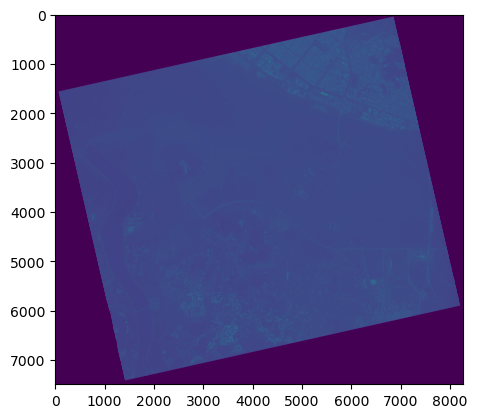

In [57]:
import rasterio
from matplotlib import pyplot
src = rasterio.open("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_B_geotiff.tif")
array = src.read(1)
pyplot.imshow(array)

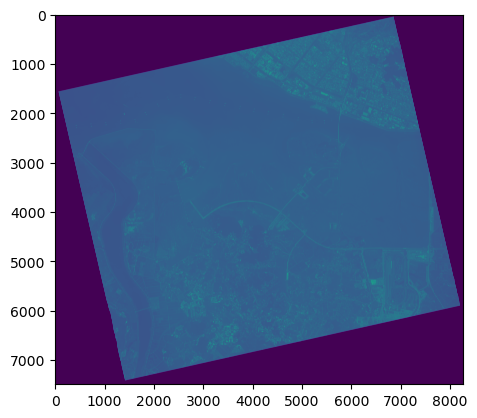

In [58]:
src = rasterio.open("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_G_geotiff.tif") # Near-infrared
array = src.read(1)
pyplot.imshow(array)

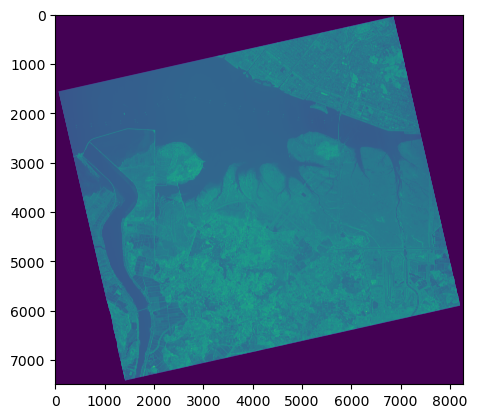

In [59]:
src = rasterio.open("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_N_geotiff.tif")
array = src.read(1)
pyplot.imshow(array)

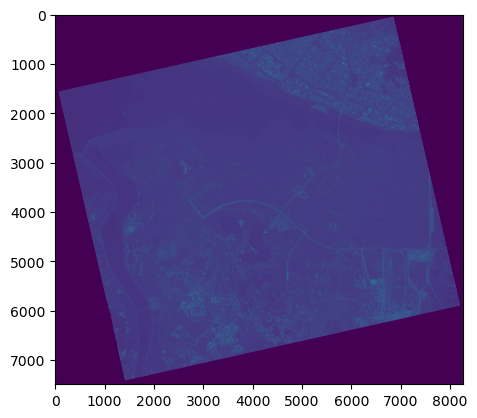

In [60]:
src = rasterio.open("./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/C1_20230624015314_12527_00071291_L2G_R_geotiff.tif")
array = src.read(1)
pyplot.imshow(array)

## xml 정보 위성사진에 매핑하기

In [3]:
tif_df = {
    'file_name':[],
    'file_path':[],
    'time':[],
    'imagegeogcenter':[],
    'imagegeogtl':[],
    'imagegeogtc':[],
    'imagegeogtr':[],
    'imagegeogbl':[],
    'imagegeogbc':[],
    'imagegeogbr':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/20.국토지리정보원_위성영상(RGB_NIR)"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 XML 파일 목록 가져오기
    xml_files = [f for f in os.listdir(directory) if f.endswith("Aux.xml")]

    # 각 XML 파일을 읽어서 처리
    for xml_file in xml_files:
        xml_file_path = os.path.join(directory, xml_file)
                
        with open(xml_file_path, 'r') as f:
            xml_doc = f.read()
        soup = bs(xml_doc, 'lxml')

        # TIFF이미지 형식 1번부터 4번까지 순회(BGRN 순)
        for img_no in range(1,5):

            # soup로 이미지 번호에 해당하는 객체 탐색
            img_lxml = soup.find("ms%s"%img_no)

            # 이미지 파일이름 추출 및 저장
            tif_df['file_name'].append(img_lxml.find('imagefilename').text)

            # 이미지 파일경로 저장
            tif_df['file_path'].append('./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624015314_12527_00071291_L2G/' + img_lxml.find('imagefilename').text)

            # UTC to yy-mm-dd 변환 및 저장
            text = img_lxml.find('utc').text.split('.')[0]
            datetime_obj = datetime.strptime(text, "%Y%m%d%H%M%S")
            tif_df['time'].append(datetime_obj.strftime("%y-%m-%d"))

            # 이미지 위치정보 저장
            img_point = ['imagegeogcenter', 'imagegeogtl', 'imagegeogtc', 'imagegeogtr', 'imagegeogbl', 'imagegeogbc', 'imagegeogbr'] # 딕셔너리 3~9 column
            lat_lst = img_lxml.find_all('latitude')
            lon_lst = img_lxml.find_all('longitude')
            for point, lat, lon in zip(img_point, lat_lst, lon_lst):
                tif_df[point].append(Point(lon, lat))

pd.DataFrame(tif_df)

,file_name,file_path,time,imagegeogcenter,imagegeogtl,imagegeogtc,imagegeogtr,imagegeogbl,imagegeogbc,imagegeogbr
0,C1_20230624015314_12527_00071291_L2G_B.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
1,C1_20230624015314_12527_00071291_L2G_G.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
2,C1_20230624015314_12527_00071291_L2G_R.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
3,C1_20230624015314_12527_00071291_L2G_N.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.709245 37.267593),POINT (126.615293 37.334427),POINT (126.708538 37.335088),POINT (126.801798 37.335675),POINT (126.616871 37.199436),POINT (126.70995 37.200093),POINT (126.803044 37.200678)
4,C1_20230624015314_12527_00093015_L2G_B.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
5,C1_20230624015314_12527_00093015_L2G_G.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
6,C1_20230624015314_12527_00093015_L2G_R.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
7,C1_20230624015314_12527_00093015_L2G_N.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-06-24,POINT (126.678512 37.370226),POINT (126.584346 37.437072),POINT (126.677775 37.437759),POINT (126.771212 37.438372),POINT (126.585986 37.302003),POINT (126.679248 37.302687),POINT (126.772517 37.303297)
8,C1_20230719015507_12907_00322813_L2G_B.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-07-19,POINT (126.869954 37.264529),POINT (126.782672 37.330089),POINT (126.869403 37.330583),POINT (126.956147 37.331014),POINT (126.783924 37.197977),POINT (126.870504 37.198468),POINT (126.957097 37.198897)
9,C1_20230719015507_12907_00322813_L2G_G.tif,./dataset/20.국토지리정보원_위성영상(RGB_NIR)/C1_20230624...,23-07-19,POINT (126.869954 37.264529),POINT (126.782672 37.330089),POINT (126.869403 37.330583),POINT (126.956147 37.331014),POINT (126.783924 37.197977),POINT (126.870504 37.198468),POINT (126.957097 37.198897)
